# Assignment 1.3: Visualizing Distributions

This exercise asks you to recreate several classic plot types from DAOST Chapter 2 using your own crime data — putting visualization theory into practice.

Draws from: Week 3, Exercises 5.2 and 5.3.

### Loading the data

In [2]:
# Import libraries and read the dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Have to parse the 'Date' column as datetime to work with it later
df = pd.read_csv("../../../Datasets/Combined_Crime_Data_2003_to_2025_Assignment1.csv", parse_dates=['Date'])

In [4]:
# Eliminate nan values in the 'Police_District' column
df = df.dropna(subset=['Police_District'])

In [5]:
# Convert Time to datetime
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.time

# Extract hour first for all data
df['Hour'] = df['Time'].apply(lambda x: x.hour if pd.notna(x) else None)

# Extract minutes for all data
df['Minute'] = df['Time'].apply(lambda x: x.minute if pd.notna(x) else None)

# Extract seconds for all data
df['Second'] = df['Time'].apply(lambda x: x.second if pd.notna(x) else None)

## Part A - Jitter Plot
Pick one of your Personal Focus Crimes and a suitable time interval (somewhere between a month and 6 months, depending on how common the crime is). Create a jitter plot of the incident times during a single hour (e.g. 13:00–14:00): let time run along the 
-axis and add vertical jitter.
What does the jitter plot reveal about how times are recorded in the dataset? Are incidents clustered at certain minutes (on the hour, half hour, etc.)? What does this tell you about the precision of the data?

### Selection of the focus crime

In this case: WARRANT

Considering a time of 3 months

In [6]:
# Select crime type and time period
crime_type = 'Warrant'
crime_data = df[(df['Incident_Category'] == crime_type) & 
                (df['Date'] >= '2024-01-01') & 
                (df['Date'] <= '2024-06-30')]

# Print the amount of crimes in the selected period
print(f"Total {crime_type} incidents the selected period: {len(crime_data)}")

Total Warrant incidents the selected period: 2223


### Visualization of the Jitter Plot

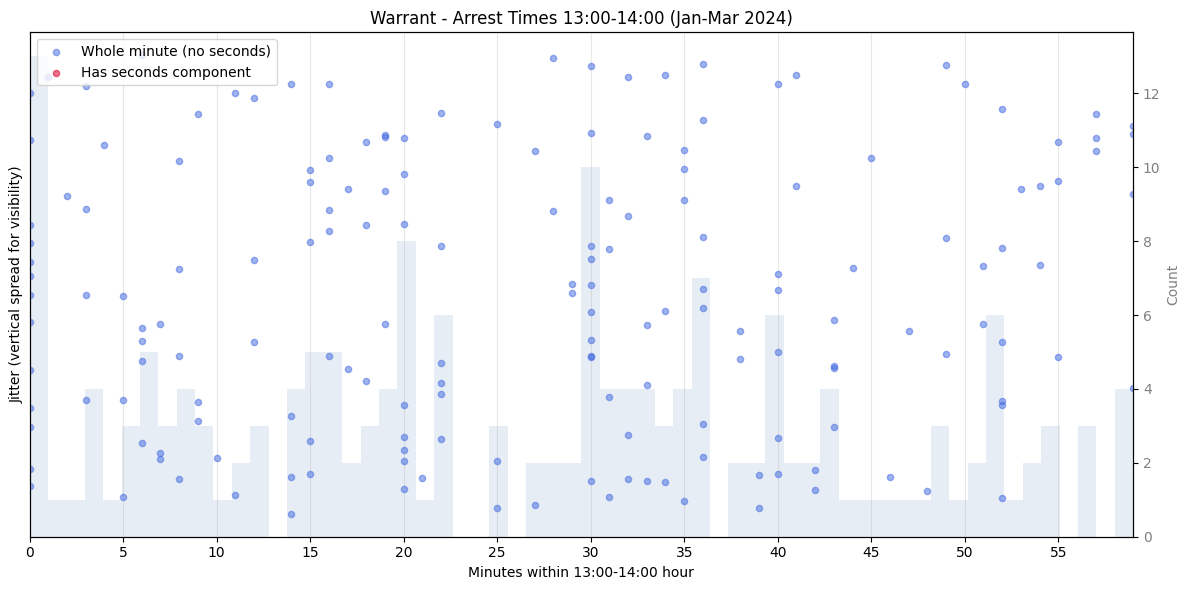

In [7]:
# Filter for specific hour (e.g., 13:00-14:00)
hour_data = crime_data[crime_data['Hour'] == 13].copy()

# Extract minutes within the hour (0-59)
hour_data['Minutes'] = hour_data['Time'].apply(
    lambda x: x.minute if pd.notna(x) else None
)

# Classify dots: has seconds (non-zero) or not
hour_data['HasSeconds'] = hour_data['Second'].apply(lambda x: x != 0 if pd.notna(x) else False)

# Create jitter plot
fig, ax = plt.subplots(figsize=(12, 6))

jitter = np.random.uniform(-0.4, 0.4, size=len(hour_data))

# Adaptation of the visualization to show the histogram behind the jitter plot

# Histogram behind
ax2 = ax.twinx()
ax2.hist(hour_data['Minutes'], bins=60, range=(0, 59), color='lightsteelblue', 
         alpha=0.3, zorder=1, label='Frequency')
ax2.set_ylabel('Count', color='gray')
ax2.tick_params(axis='y', labelcolor='gray')
ax2.set_zorder(1)

# Jitter plot in front
ax.set_zorder(2) 
ax.patch.set_visible(False)  # make scatter background transparent

mask_no_seconds = ~hour_data['HasSeconds']
mask_has_seconds = hour_data['HasSeconds']

ax.scatter(hour_data.loc[mask_no_seconds, 'Minutes'], jitter[mask_no_seconds],
            alpha=0.5, s=20, color='royalblue', label='Whole minute (no seconds)', zorder=2)
ax.scatter(hour_data.loc[mask_has_seconds, 'Minutes'], jitter[mask_has_seconds],
            alpha=0.6, s=20, color='crimson', label='Has seconds component', zorder=2)

# This part must be changed in case of selecting another time (manual)
ax.set_xlabel('Minutes within 13:00-14:00 hour')
ax.set_ylabel('Jitter (vertical spread for visibility)')
ax.set_title(f'{crime_type} - Arrest Times 13:00-14:00 (Jan-Mar 2024)')
ax.set_yticks([])
ax.set_xlim(0, 59)
ax.set_xticks(range(0, 60, 5))
ax.grid(axis='x', alpha=0.3)
ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

## Part B - Probability Plot
Using the same geographic data from Part B, create a probability plot (QQ plot) for the latitude distribution of each of your two crime types. (scipy.stats.probplot is your friend here.)
What reference distribution are you comparing against? What would it mean if the points fell exactly on the straight line? Where does the distribution deviate from normal, and what does that deviation tell you about the geography of crime in SF?

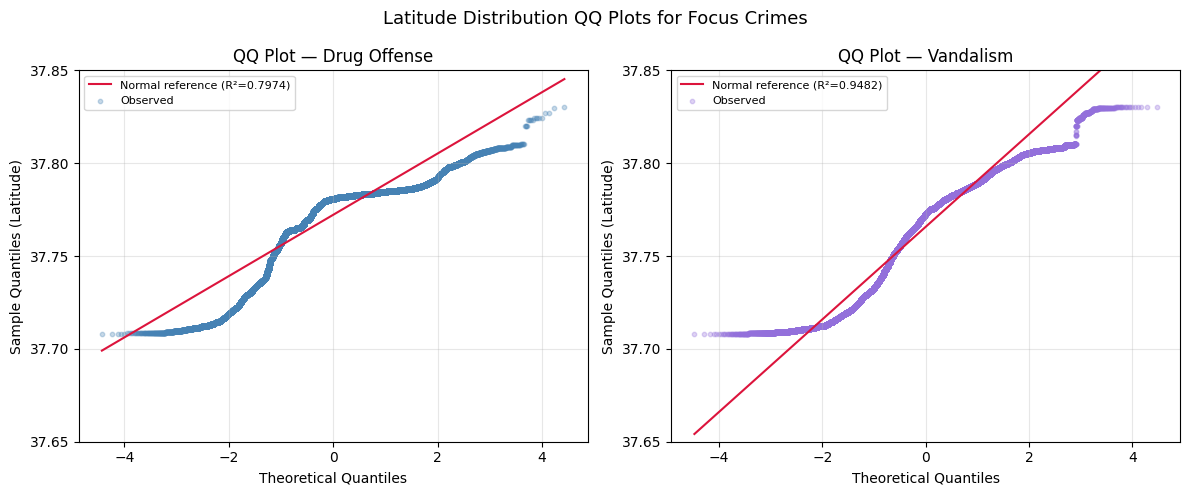

In [14]:
from scipy import stats

# Remove impossible coordinates
crimes_of_interest = ['Drug Offense', 'Vandalism']
colors = ['steelblue', 'mediumpurple']

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for ax, (crime, color) in zip(axes, zip(crimes_of_interest, colors)):
    valid_data = df[
        (df['Incident_Category'] == crime) &
        (df['Latitude'] > 37.0) & (df['Latitude'] < 38.0) &
        (df['Longitude'] > -123.0) & (df['Longitude'] < -122.0)
    ].dropna(subset=['Latitude'])

    latitudes = valid_data['Latitude'].values

    (osm, osr), (slope, intercept, r) = stats.probplot(latitudes, dist='norm')

    # Reference line
    ax.plot(osm, slope * np.array(osm) + intercept, color='crimson',
            linewidth=1.5, label=f'Normal reference (R²={r**2:.4f})')

    # Data points
    ax.scatter(osm, osr, alpha=0.3, s=10, color=color, label='Observed')

    ax.set_title(f'QQ Plot — {crime}')
    ax.set_xlabel('Theoretical Quantiles')
    ax.set_ylabel('Sample Quantiles (Latitude)')
    ax.set_ylim(37.65, 37.85)
    ax.set_yticks(np.arange(37.65, 37.86, 0.05))
    ax.legend(fontsize=8)
    ax.grid(alpha=0.3)

plt.suptitle('Latitude Distribution QQ Plots for Focus Crimes', fontsize=13)
plt.tight_layout()
plt.show()

## Part C — Box plots of time-of-day

For each of your Personal Focus Crimes, extract the time-of-day of every incident.
Create box plots showing the time-of-day distribution for all your Personal Focus Crimes side by side.
What patterns do you see? Are there crimes that happen mostly at night? Mostly during business hours? For crimes that peak late at night, does the box plot handle the wrap-around at midnight well? What goes wrong?
Above, feel free to use alternatives to box plots — violin plots, swarm plots, or raincloud plots — if you think they reveal more. If you do, briefly explain what the alternative shows that the box plot doesn't.

### Visualization of the Focus Crimes (boxplot)

C:\Users\ogonz\AppData\Local\Temp\ipykernel_28508\2394078158.py:34: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data_to_plot,


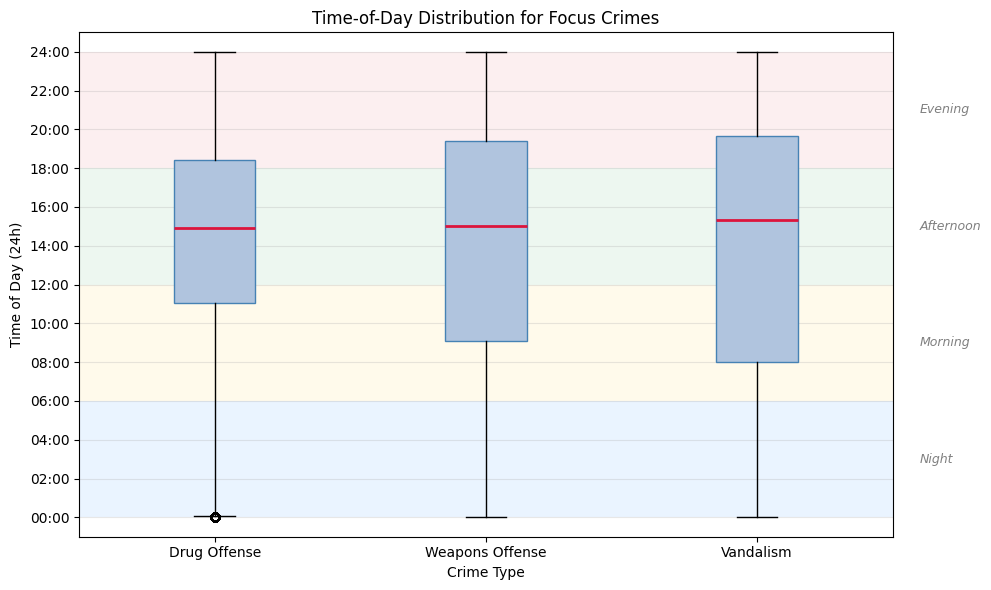

In [8]:
# Filter for focus crimes
focus_crimes = ['Drug Offense', 'Weapons Offense', 'Vandalism']

focus_data = df[df['Incident_Category'].isin(focus_crimes)].copy()

# Convert to seconds since midnight
focus_data['Seconds_since_midnight'] = focus_data['Time'].apply(
    lambda x: x.hour * 3600 + x.minute * 60 + x.second if pd.notna(x) else None
)

# Define time-of-day periods (in seconds)
periods = [
    (0,      6*3600,  'Night',     '#cce5ff'),
    (6*3600, 12*3600, 'Morning',   '#fff3cd'),
    (12*3600,18*3600, 'Afternoon', '#d4edda'),
    (18*3600,24*3600, 'Evening',   '#f8d7da'),
]

# Prepare data
data_to_plot = [
    focus_data[focus_data['Incident_Category'] == crime]['Seconds_since_midnight'].dropna().values
    for crime in focus_crimes
]

# Create plot
fig, ax = plt.subplots(figsize=(10, 6))

# Add background shading for each period
for start, end, label, color in periods:
    ax.axhspan(start, end, facecolor=color, alpha=0.4, zorder=0)
    ax.text(len(focus_crimes) + 0.6, (start + end) / 2, label,
            va='center', ha='left', fontsize=9, color='gray', style='italic')

ax.boxplot(data_to_plot,
           labels=focus_crimes,
           patch_artist=True,
           boxprops=dict(facecolor='lightsteelblue', color='steelblue'),
           medianprops=dict(color='crimson', linewidth=2),
           zorder=2)

# Y-axis in hours
hours = range(0, 25, 2)
ax.set_yticks([h * 3600 for h in hours])
ax.set_yticklabels([f'{h:02d}:00' for h in hours])
ax.set_ylim(-1 * 3600, 25 * 3600)

ax.set_xlabel('Crime Type')
ax.set_ylabel('Time of Day (24h)')
ax.set_title('Time-of-Day Distribution for Focus Crimes')
ax.grid(axis='y', alpha=0.3, zorder=1)
plt.tight_layout()
plt.show()

### Visualization of Focus Crimes in raincloud plots

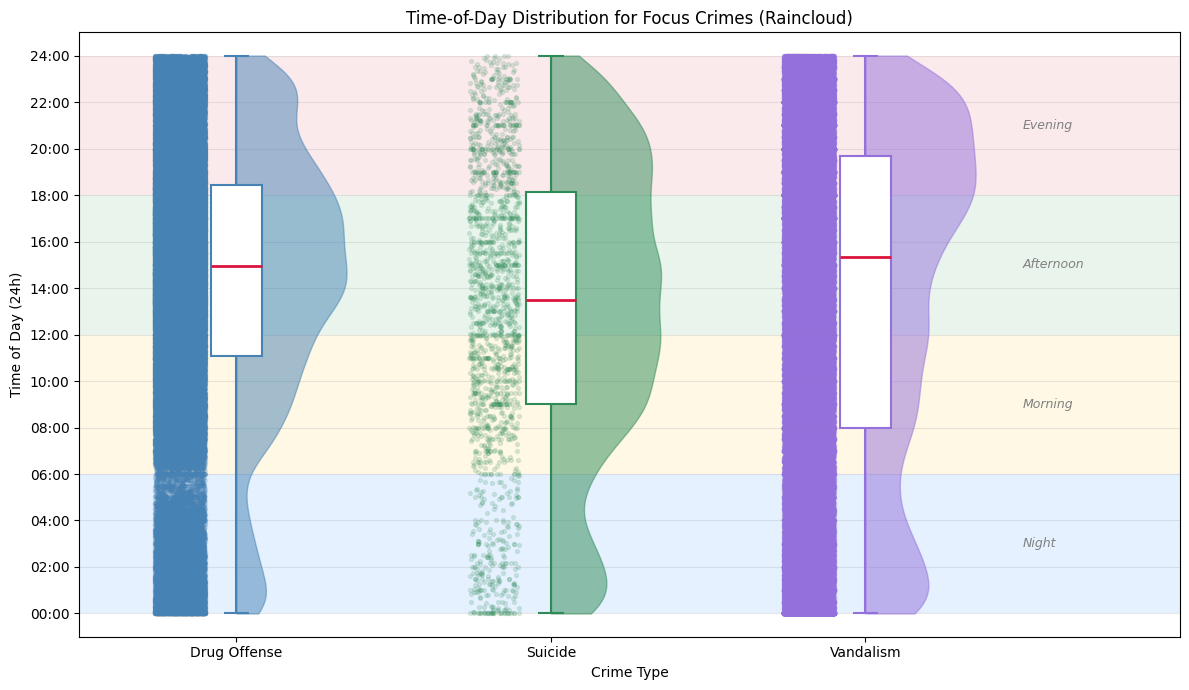

In [9]:
from scipy.stats import gaussian_kde

# Filter for focus crimes
focus_crimes = ['Drug Offense', 'Suicide', 'Vandalism']

focus_data = df[df['Incident_Category'].isin(focus_crimes)].copy()

# Convert to seconds since midnight (there seems to not be seconds, still better to handle them in any case)
focus_data['Seconds_since_midnight'] = focus_data['Time'].apply(
    lambda x: x.hour * 3600 + x.minute * 60 + x.second if pd.notna(x) else None
).astype(float)

focus_data = focus_data.dropna(subset=['Seconds_since_midnight'])

# Define time-of-day periods (in seconds)
periods = [
    (0,       6*3600,  'Night',     '#cce5ff'),
    (6*3600,  12*3600, 'Morning',   '#fff3cd'),
    (12*3600, 18*3600, 'Afternoon', "#d4edda"),
    (18*3600, 24*3600, 'Evening',   '#f8d7da'),
]

colors = ['steelblue', 'seagreen', 'mediumpurple']
y_range = np.linspace(0, 24 * 3600, 500)

fig, ax = plt.subplots(figsize=(12, 7))

# Background period shading
for start, end, label, color in periods:
    ax.axhspan(start, end, facecolor=color, alpha=0.5, zorder=0)
    ax.text(len(focus_crimes) + 0.5, (start + end) / 2, label,
            va='center', ha='left', fontsize=9, color='gray', style='italic')

for i, (crime, color) in enumerate(zip(focus_crimes, colors)):
    x_pos = i + 1
    values = focus_data[focus_data['Incident_Category'] == crime]['Seconds_since_midnight'].values

    # KDE (density) plot
    kde = gaussian_kde(values, bw_method=0.15)
    kde_vals = kde(y_range)
    kde_vals_scaled = kde_vals / kde_vals.max() * 0.35  # normalize width
    ax.fill_betweenx(y_range, x_pos, x_pos + kde_vals_scaled,
                     alpha=0.5, color=color, zorder=2)

    # Boxplot 
    q1, median, q3 = np.percentile(values, [25, 50, 75])
    iqr = q3 - q1
    lower_whisker = max(values.min(), q1 - 1.5 * iqr)
    upper_whisker = min(values.max(), q3 + 1.5 * iqr)

    box_width = 0.08
    ax.add_patch(plt.Rectangle((x_pos - box_width, q1), box_width * 2, iqr,
                                facecolor='white', edgecolor=color, linewidth=1.5, zorder=3))
    ax.hlines(median, x_pos - box_width, x_pos + box_width,
              color='crimson', linewidth=2, zorder=4)
    ax.vlines(x_pos, lower_whisker, q1, color=color, linewidth=1.5, zorder=3)
    ax.vlines(x_pos, q3, upper_whisker, color=color, linewidth=1.5, zorder=3)
    ax.hlines([lower_whisker, upper_whisker], x_pos - box_width / 2, x_pos + box_width / 2,
              color=color, linewidth=1.5, zorder=3)

    # Jitter plot
    jitter = np.random.uniform(-0.08, 0.08, size=len(values))
    ax.scatter(x_pos - 0.18 + jitter, values,
               alpha=0.15, s=8, color=color, zorder=2)

# Y-axis in hours (made decimals, but shown as time hours)
hours = range(0, 25, 2)
ax.set_yticks([h * 3600 for h in hours])
ax.set_yticklabels([f'{h:02d}:00' for h in hours])
ax.set_ylim(-1 * 3600, 25 * 3600)

ax.set_xticks(range(1, len(focus_crimes) + 1))
ax.set_xticklabels(focus_crimes)
ax.set_xlim(0.5, len(focus_crimes) + 1)

ax.set_xlabel('Crime Type')
ax.set_ylabel('Time of Day (24h)')
ax.set_title('Time-of-Day Distribution for Focus Crimes (Raincloud)')
ax.grid(axis='y', alpha=0.3, zorder=1)
plt.tight_layout()
plt.show()

### Visualization of Focus Crimes in Polar Histogram

          Crime Circular Mean Time
0  Drug Offense              15:54
1       Suicide              15:06
2     Vandalism              19:28


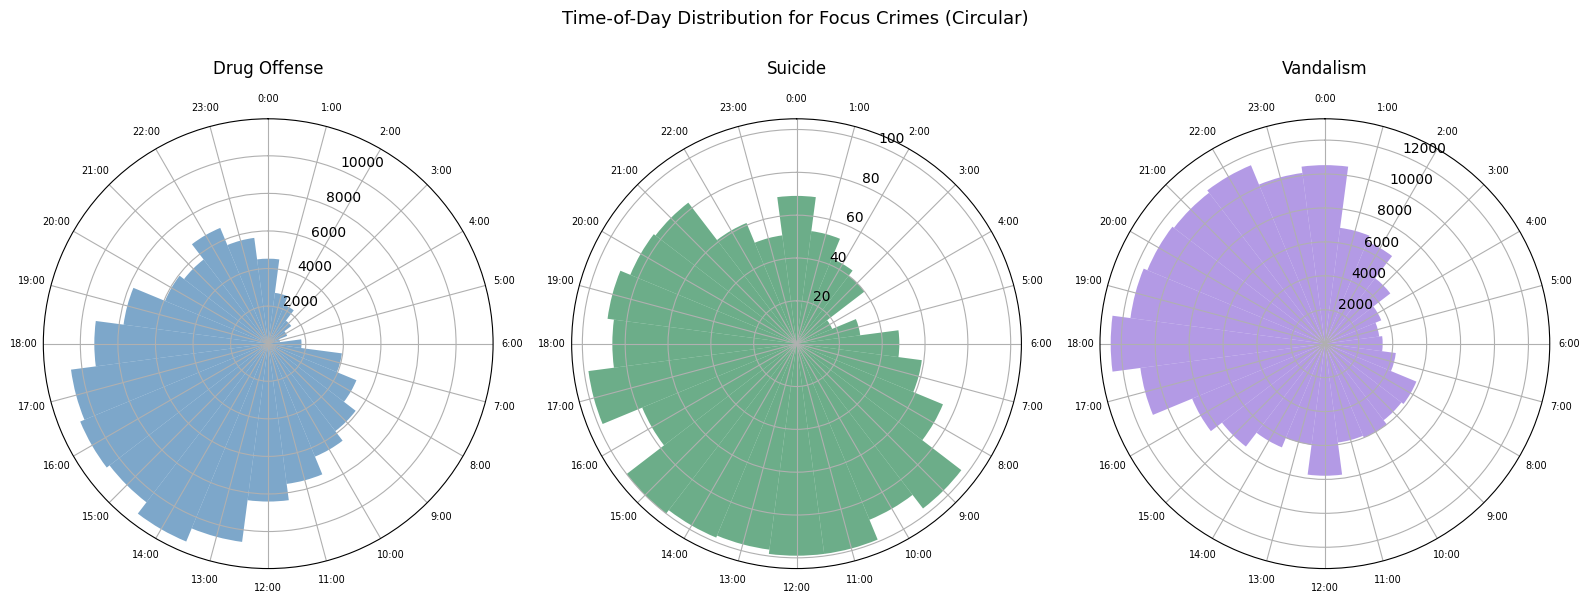

In [11]:
import numpy as np

# Convert times to angles (radians)
focus_data['Time_angle'] = focus_data['Seconds_since_midnight'].apply(
    lambda x: (x / 86400) * 2 * np.pi if pd.notna(x) else None
)

# Focus crimes
focus_crimes = ['Drug Offense', 'Suicide', 'Vandalism']
crime_times = focus_data[focus_data['Incident_Category'].isin(focus_crimes)][['Incident_Category', 'Time_angle']].dropna()

# Calculate circular statistics for each crime
results = []
for crime in focus_crimes:
    angles = crime_times[crime_times['Incident_Category'] == crime]['Time_angle'].values
    
    if len(angles) == 0:
        results.append({'Crime': crime, 'Circular Mean Time': 'N/A'})
        continue

    # Circular mean
    sin_mean = np.sin(angles).mean()
    cos_mean = np.cos(angles).mean()
    circular_mean = np.arctan2(sin_mean, cos_mean)
    if circular_mean < 0:
        circular_mean += 2 * np.pi
    
    # Convert back to time
    mean_seconds = (circular_mean / (2 * np.pi)) * 86400
    mean_hour = mean_seconds / 3600

    if np.isnan(mean_hour):
        mean_time_str = 'N/A'
    else:
        mean_time_str = f"{int(mean_hour):02d}:{int((mean_hour % 1) * 60):02d}"

    results.append({
        'Crime': crime,
        'Circular Mean Time': mean_time_str
    })

results_df = pd.DataFrame(results)
print(results_df)

# Polar histogram visualization
fig, axes = plt.subplots(1, 3, figsize=(16, 6), subplot_kw=dict(projection='polar'))

colors = ['steelblue', 'seagreen', 'mediumpurple']

for i, (crime, color) in enumerate(zip(focus_crimes, colors)):
    angles = crime_times[crime_times['Incident_Category'] == crime]['Time_angle'].values

    if len(angles) == 0:
        axes[i].set_title(f'{crime}\n(no data)', pad=15)
        continue

    # Create histogram
    bins = np.linspace(0, 2*np.pi, 25)
    counts, _ = np.histogram(angles, bins=bins)
    
    # Plot
    width = 2*np.pi / 24
    axes[i].bar(bins[:-1], counts, width=width, alpha=0.7, color=color)
    axes[i].set_theta_zero_location('N')
    axes[i].set_theta_direction(-1)
    axes[i].set_title(crime, pad=15)
    
    # Time labels
    axes[i].set_xticks(np.linspace(0, 2*np.pi, 24, endpoint=False))
    axes[i].set_xticklabels([f'{h}:00' for h in range(24)], fontsize=7)

plt.suptitle('Time-of-Day Distribution for Focus Crimes (Circular)', y=1.02, fontsize=13)
plt.tight_layout()
plt.show()

# Assignment 1.4: Spatial Power Law

Is crime spread evenly across San Francisco, or is it concentrated in a small number of hotspots? Let's find out.

Draws from: Week 4, Exercise 2.2.

Use your most common Personal Focus Crime (by total incident count) for this exercise.

### Getting the most common focus crimes

In [36]:
# Most common crime types
top_crimes = df['Incident_Category'].value_counts().head(3)
print("Top 10 Crime Types:")
print(top_crimes)

Top 10 Crime Types:
Incident_Category
Larceny Theft    753962
Assault          227344
Vandalism        182394
Name: count, dtype: int64


### Step 1
Divide San Francisco into a grid of approximately **100m × 100m** cells using latitude and longitude. It is fine to ignore that the Earth isn't flat — the approximation is good enough for this purpose.
- **Hint**: `np.histogram2d` works well here. Focus on points within the SF peninsula; filter out geographic outliers.

In [37]:
# As shown in https://github.com/suneman/socialdata2022/blob/main/lectures/Week5_binning.ipynb

import pandas as pd
from math import radians, cos, sin, asin, sqrt
import numpy as np
import matplotlib.pyplot as plt

# Limit the data to only the Theft incidents
data = df[df['Incident_Category'] == 'Larceny Theft']

# Remove impossible coordinates
data = df[(df['Latitude'] > 37.0) & (df['Latitude'] < 38.0) &
                (df['Longitude'] > -123.0) & (df['Longitude'] < -122.0)]

# Consider min and max latitudes and longitudes
lat_min = data['Latitude'].min()
lat_max = data['Latitude'].max()
lon_min = data['Longitude'].min()
lon_max = data['Longitude'].max()

print(f"Latitude range: {lat_min} to {lat_max}")
print(f"Longitude range: {lon_min} to {lon_max}")
print("----------------------------------")

# Adjust the Latitude and Longitude (ex. data = data[(data.Y < 50) & (data.X<-122)])
data = data[
    (data['Latitude'] >= lat_min) & (data['Latitude'] <= lat_max) &
    (data['Longitude'] >= lon_min) & (data['Longitude'] <= lon_max)
]

# Haversine formula to calculate the distance between two points on the Earth
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

# Gives in km, so changed to 100 meters by multiplying by 10
print(f"Estimated bin amount along the western border of San Fransisco: {haversine(lon_min, lat_min, lon_min, lat_max)*10}") 
print(f"Estimated bin amount along the eastern border of San Fransisco: {haversine(lon_max, lat_min, lon_max, lat_max)*10}")
print(f"Estimated bin amount along the northern border of San Fransisco: {haversine(lon_min, lat_max, lon_max, lat_max)*10}")
print(f"Estimated bin amount along the southern border of San Fransisco: {haversine(lon_min, lat_min, lon_max, lat_min)*10}")


Latitude range: 37.70784759521 to 37.83005523682
Longitude range: -122.51364206429 to -122.36475070439
----------------------------------
Estimated bin amount along the western border of San Fransisco: 135.8886974422834
Estimated bin amount along the eastern border of San Fransisco: 135.8886974422834
Estimated bin amount along the northern border of San Fransisco: 130.76451751701455
Estimated bin amount along the southern border of San Fransisco: 130.98079996186993


### Step 2
Count the number of incidents of your chosen crime in each grid cell (use all years of data).

In [38]:
# Approximate amount of bins 136 and 128 for longitude and latitude respectively

count, lon, lat = np.histogram2d(data['Latitude'], data['Longitude'], bins = [136,131])

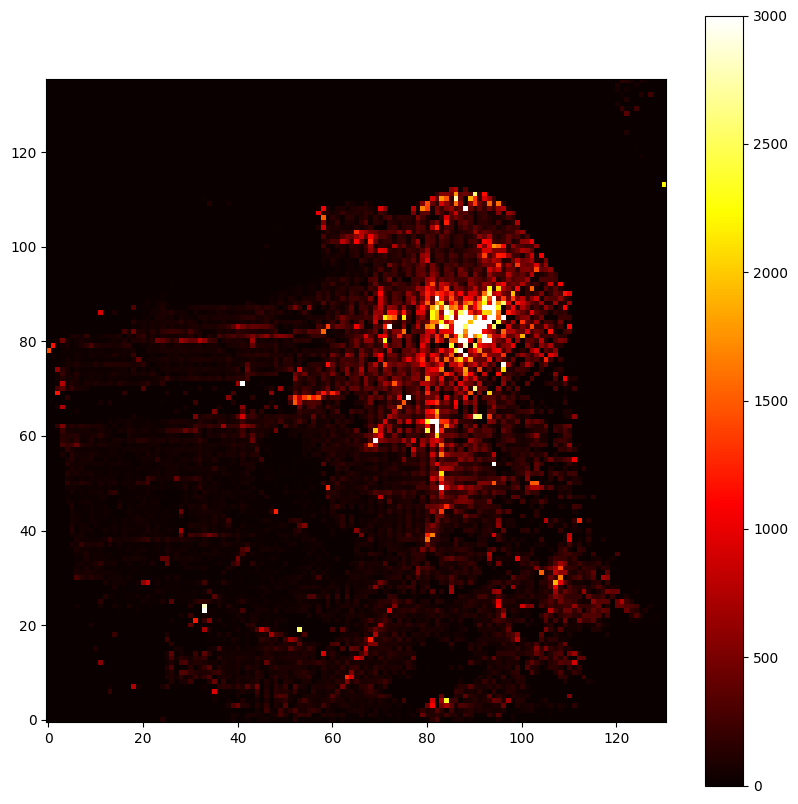

In [39]:
# Review with a plot
plt.figure(figsize=(10,10))
plt.imshow(count, cmap='hot',vmax=3000, origin='lower')
plt.colorbar()

### Step 3
Tally the distribution. Count how many cells have exactly $k$ incidents — call this $N(k)$ — for $k = 0, 1, 2, \ldots$ up to the maximum.

In [40]:
# Find the max count of incidents in a bin
print(f"Max count of incidents in a bin: {count.max()}")

Max count of incidents in a bin: 35055.0


In [41]:
# 1D change to calculate easily the number of bins with k incidents
bin_counts = count.flatten()

# Calculate N_k, the number of bins with k incidents, for k = 0, 1, 2, ..., C_max
C_max = int(bin_counts.max())  # 2694
N_k = np.zeros(C_max + 1)

for k in range(C_max + 1):
    N_k[k] = (bin_counts == k).sum()

### Step 4
Plot $(k + 1)$ vs $N(k)$ on **linear axes**.

Text(0.5, 1.0, 'Distribution of incidents per bin')

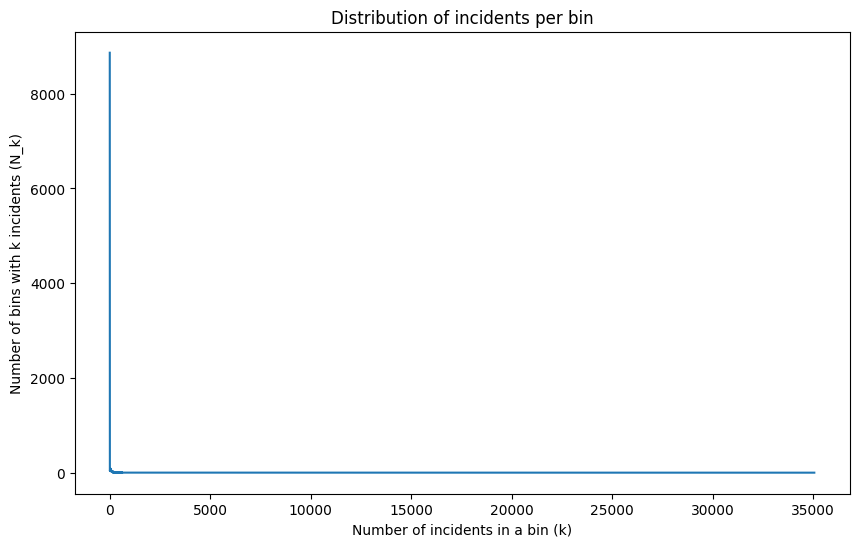

In [45]:
# Plot the distribution of k+1 vs N_k on linear scale
plt.figure(figsize=(10, 6))
plt.plot(range(C_max + 1), N_k)
plt.xlabel('Number of incidents in a bin (k)')
plt.ylabel('Number of bins with k incidents (N_k)')
plt.title('Distribution of incidents per bin')

### Step 5
Plot $(k + 1)$ vs $N(k)$ on **loglog axes**.

Text(0.5, 1.0, 'Distribution of incidents per bin (Log-Log Scale)')

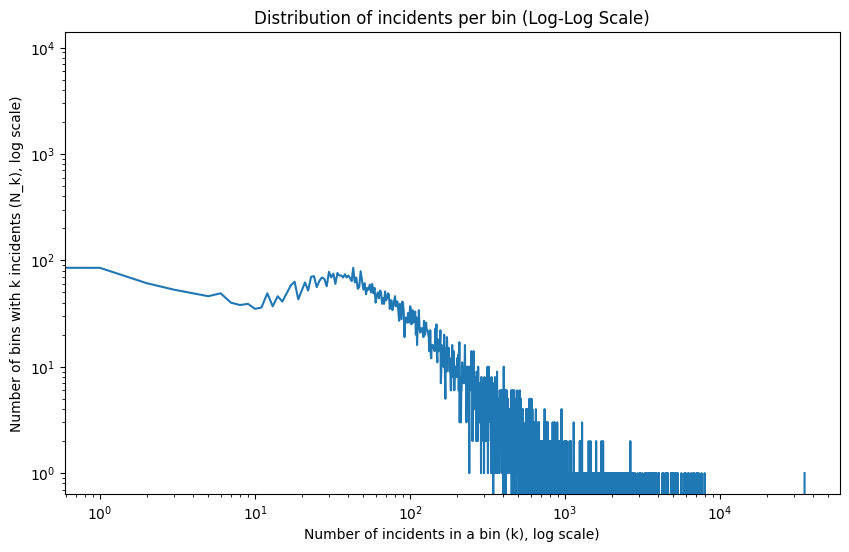

In [43]:
# Plot the distribution of k+1 vs N_k on loglog scale
plt.figure(figsize=(10, 6))
plt.plot(range(C_max + 1), N_k)
plt.xlabel('Number of incidents in a bin (k), log scale)')
plt.ylabel('Number of bins with k incidents (N_k), log scale)')
plt.xscale('log')
plt.yscale('log')
plt.title('Distribution of incidents per bin (Log-Log Scale)')

### Step 6
Does your crime follow a power-law spatial distribution? How can you tell from the loglog plot?

### Step 7
If crime is spatially concentrated in a small number of cells, what does that imply for how we interpret neighborhood-level crime statistics? Does the "average block" tell you anything useful?